In [26]:
!pip install --upgrade scikit-learn==1.5.2

In [27]:
import sklearn
print(sklearn.__version__)

1.5.2


In [28]:
# 1. IMPORT LIBRARIES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json, os, warnings, joblib
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, roc_curve)
from xgboost import XGBClassifier

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [29]:
# 2. LOAD THE DATASET

print(" Searching for dataset files...")
dataset_path = '/kaggle/input/ransomware-detection-data-set/data_file.csv'
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.endswith('.csv'):
            full_path = os.path.join(dirname, filename)
            
            if 'ransomware' in filename.lower() or 'malware' in filename.lower():
                dataset_path = '/kaggle/input/ransomware-detection-data-set/data_file.csv'
                print(f"   Found potential dataset: {full_path}")
if dataset_path:
    df = pd.read_csv('/kaggle/input/ransomware-detection-data-set/data_file.csv')
    print(f" Dataset loaded successfully: {df.shape[0]} rows, {df.shape[1]} columns")
else:
    # Fallback: If automatic detection fails, specify the exact path from the Kaggle data panel
    print("   Could not auto-detect. Please specify path.")
    # Example manual path (you will likely need to adjust this):
    # df = pd.read_csv('/kaggle/input/ransomware-detection-data-set/your_file_name.csv')

# Display first rows and basic info
print("\n First look at the data:")
print(df.head())
print(f"\n  Column names: {df.columns.tolist()[:15]}...")  # Show first 15 columns

 Searching for dataset files...
 Dataset loaded successfully: 62485 rows, 18 columns

 First look at the data:
                                            FileName  \
0           0124e21d-018c-4ce0-92a3-b9e205a76bc0.dll   
1       05c8318f98a5d301d80000009c316005.vertdll.dll   
2           06054fba-5619-4a86-a861-ffb0464bef5d.dll   
3        075822ac99a5d301660400009c316005.adhapi.dll   
4  090607dd9ba5d301ca0900009c316005.SensorsNative...   

                            md5Hash  Machine  DebugSize  DebugRVA  \
0  79755c51e413ed3c6be4635fd729a6e1      332          0         0   
1  95e19f3657d34a432eada93221b0ea16    34404         84    121728   
2  85c32641d77a54e19ba8ea4ab305c791      332          0         0   
3  62e3b959d982ef534b66f819fe15f085    34404         84     19904   
4  ae38c5f7d313ad0ff3bfb8826476767f    34404         84     97728   

   MajorImageVersion  MajorOSVersion  ExportRVA  ExportSize  IatVRA  \
0                  0               4          0           0    819


EXPLORATORY DATA ANALYSIS (EDA)

 3.1 DATASET OVERVIEW
----------------------------------------
Dataset Shape: 62485 rows × 18 columns

Column Data Types:
int64     16
object     2
Name: count, dtype: int64

Memory Usage: 18.44 MB

 3.2 TARGET COLUMN IDENTIFICATION
----------------------------------------
ALL COLUMNS IN YOUR DATASET:
   1. FileName
   2. md5Hash
   3. Machine
   4. DebugSize
   5. DebugRVA
   6. MajorImageVersion
   7. MajorOSVersion
   8. ExportRVA
   9. ExportSize
  10. IatVRA
  11. MajorLinkerVersion
  12. MinorLinkerVersion
  13. NumberOfSections
  14. SizeOfStackReserve
  15. DllCharacteristics
  16. ResourceSize
  17. BitcoinAddresses
  18. Benign

POTENTIAL TARGET COLUMNS FOUND: []
 No common target column names found. Manual inspection required.

 3.3 STATISTICAL SUMMARY
----------------------------------------
Numerical Features Summary:
                      count           mean           std  min     25%     50%  \
Machine             62485.0    6756.472657

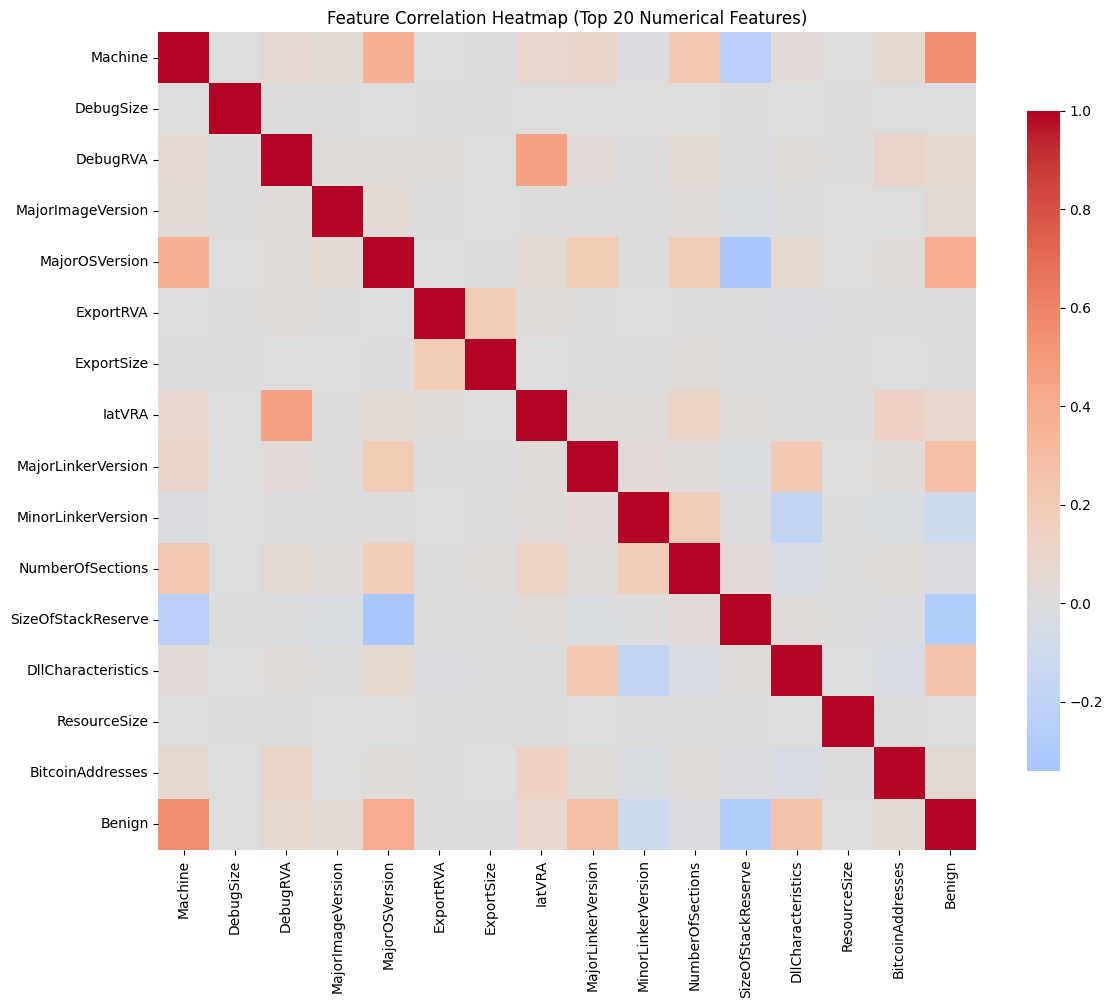

 No extremely high correlations found among top features.

 3.7 FEATURE DISTRIBUTIONS (Examples)
----------------------------------------


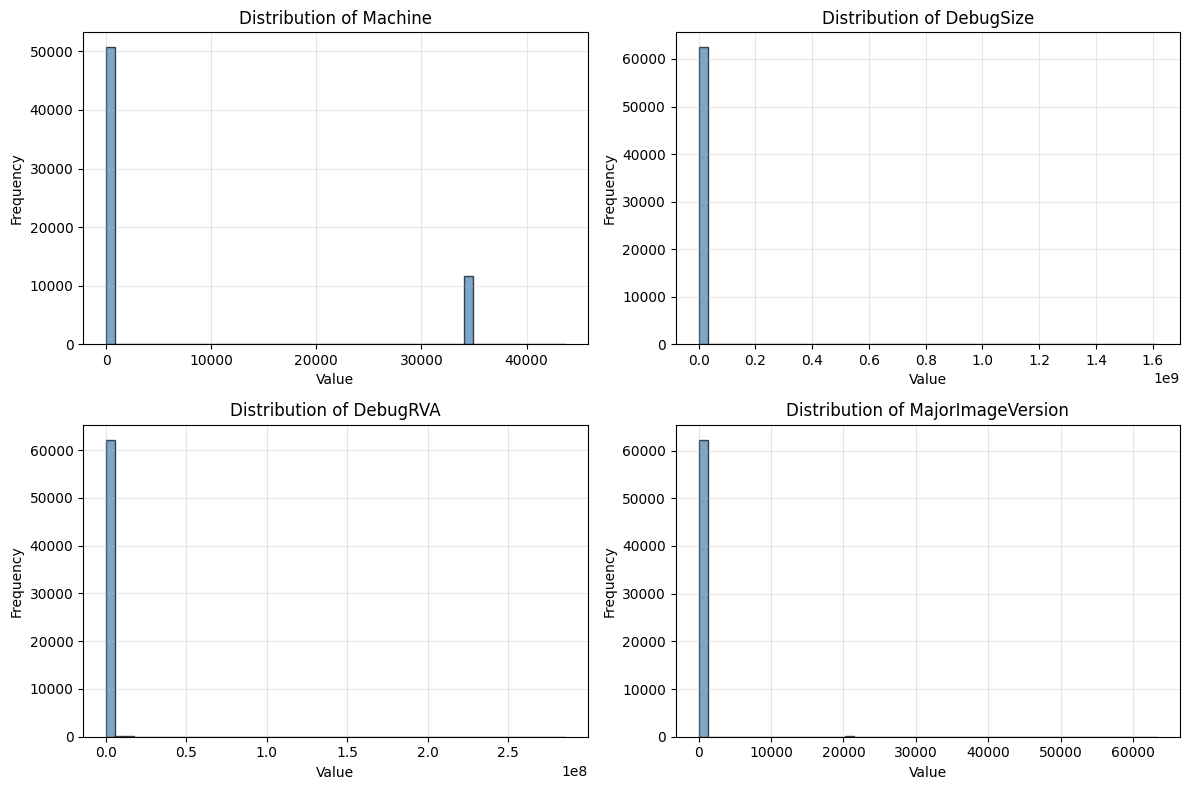

Displayed distributions for: ['Machine', 'DebugSize', 'DebugRVA', 'MajorImageVersion']

EDA COMPLETE! NEXT: Data Preprocessing


In [30]:
# 3. EXPLORATORY DATA ANALYSIS (EDA)

print("\n" + "="*60)
print("EXPLORATORY DATA ANALYSIS (EDA)")
print("="*60)

# 3.1 Initial Dataset Overview

print("\n 3.1 DATASET OVERVIEW")
print("-" * 40)
print(f"Dataset Shape: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"\nColumn Data Types:")
print(df.dtypes.value_counts())
print(f"\nMemory Usage: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# 3.2 Identify Target Column (AUTOMATED DIAGNOSIS)

print("\n 3.2 TARGET COLUMN IDENTIFICATION")
print("-" * 40)

# List all columns for manual inspection
print("ALL COLUMNS IN YOUR DATASET:")
for i, col in enumerate(df.columns.tolist(), 1):
    print(f"  {i:2d}. {col}")

# Common target column names in malware datasets
common_targets = ['Malware', 'malware', 'legitimate', 'Label', 'label', 
                  'Class', 'class', 'type', 'Target', 'target', 'infection']

# Check which exist
existing_targets = [col for col in common_targets if col in df.columns]
print(f"\nPOTENTIAL TARGET COLUMNS FOUND: {existing_targets}")

if existing_targets:
    print("\nINSPECTING POTENTIAL TARGET COLUMNS:")
    for target_candidate in existing_targets:
        unique_vals = df[target_candidate].unique()[:5]  # Show first 5 unique values
        value_counts = df[target_candidate].value_counts()
        print(f"\n  '{target_candidate}':")
        print(f"    Unique values (sample): {unique_vals}")
        print(f"    Value counts: {len(value_counts)} categories")
        print(f"    Most common: {value_counts.head(3).to_dict()}")
        
        # Check if it looks like a binary target
        if len(value_counts) == 2:
            print(f"     Likely binary target (good candidate)")
            # Try to determine mapping
            if set(value_counts.index).issubset({0, 1}):
                if df[target_candidate].mean() > 0.5:
                    print(f"    Interpretation: 1=Malicious, 0=Benign")
                else:
                    print(f"    Interpretation: 1=Benign, 0=Malicious")
else:
    print(" No common target column names found. Manual inspection required.")

# 3.3 Statistical Summary

print("\n 3.3 STATISTICAL SUMMARY")
print("-" * 40)

print("Numerical Features Summary:")
print(df.describe().transpose().head(10))  # Show first 10 numerical features

# 3.4 Missing Values Analysis

print("\n 3.4 MISSING VALUES ANALYSIS")
print("-" * 40)

missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

missing_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
}).sort_values('Missing Values', ascending=False)

# Show columns with missing values
missing_columns = missing_df[missing_df['Missing Values'] > 0]
if len(missing_columns) > 0:
    print("Columns with missing values:")
    print(missing_columns.head(15))
    
    # Visualize missing values
    plt.figure(figsize=(12, 6))
    missing_columns_head = missing_columns.head(20)  # Top 20 columns
    plt.barh(missing_columns_head.index, missing_columns_head['Percentage'])
    plt.xlabel('Missing Values (%)')
    plt.title('Top Columns with Missing Values')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print(" No missing values found in any column!")

# 3.5 Class Distribution (Once Target is Identified)

print("\n 3.5 CLASS DISTRIBUTION VISUALIZATION")
print("-" * 40)

TARGET_COLUMN = 'Malware'  

if TARGET_COLUMN in df.columns:
    print(f"Analyzing target column: '{TARGET_COLUMN}'")
    
    # Create standardized Label column for consistency
    if TARGET_COLUMN == 'legitimate':
        # If 1=legitimate (benign), invert to make 1=malicious
        df['Label'] = df[TARGET_COLUMN].apply(lambda x: 0 if x == 1 else 1)
        print("  (Converted 'legitimate' column: 1=Benign → 0=Benign, 0=Malicious → 1=Malicious)")
    else:
        # Assume column already has 1=malicious, 0=benign
        df['Label'] = df[TARGET_COLUMN]
    
    # Analyze distribution
    class_dist = df['Label'].value_counts()
    class_names = {0: 'Benign', 1: 'Malicious/Ransomware'}
    
    print(f"\nCLASS DISTRIBUTION:")
    for label, count in class_dist.items():
        percentage = (count / len(df)) * 100
        print(f"  {class_names.get(label, label)} ({label}): {count:,} samples ({percentage:.1f}%)")
    
    # Check for class imbalance
    imbalance_ratio = class_dist.max() / class_dist.min()
    if imbalance_ratio > 5:
        print(f"  Significant class imbalance detected: {imbalance_ratio:.1f}:1 ratio")
        print("   Consider techniques like SMOTE or class weighting in your model.")
    
    # Visualize class distribution
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Bar plot
    axes[0].bar(class_names.values(), class_dist.values, color=['skyblue', 'salmon'])
    axes[0].set_title('Class Distribution')
    axes[0].set_ylabel('Number of Samples')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Add count labels on bars
    for i, count in enumerate(class_dist.values):
        axes[0].text(i, count + max(class_dist.values)*0.01, f'{count:,}', 
                    ha='center', va='bottom', fontweight='bold')
    
    # Pie chart
    axes[1].pie(class_dist.values, labels=class_names.values(), autopct='%1.1f%%',
               colors=['skyblue', 'salmon'], startangle=90)
    axes[1].set_title('Class Proportion')
    
    plt.tight_layout()
    plt.show()
    
else:
    print(f"  Target column '{TARGET_COLUMN}' not found!")
    print("   Please set TARGET_COLUMN to one of the columns listed above.")
    print(f"   Available columns: {list(df.columns)[:15]}...")

# 3.6 Feature Correlation Analysis

print("\n 3.6 FEATURE CORRELATION ANALYSIS")
print("-" * 40)

# Select only numerical columns for correlation
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()

if len(numerical_cols) > 1:
    # Limit to top 20 numerical columns to avoid huge correlation matrix
    top_numerical = numerical_cols[:20]
    
    print(f"Calculating correlations for {len(top_numerical)} numerical features...")
    corr_matrix = df[top_numerical].corr()
    
    # Plot heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
                square=True, cbar_kws={"shrink": 0.8})
    plt.title('Feature Correlation Heatmap (Top 20 Numerical Features)')
    plt.tight_layout()
    plt.show()
    
    # Find highly correlated features (for feature engineering)
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i+1, len(corr_matrix.columns)):
            if abs(corr_matrix.iloc[i, j]) > 0.8:  # Threshold for high correlation
                high_corr_pairs.append((
                    corr_matrix.columns[i], 
                    corr_matrix.columns[j], 
                    corr_matrix.iloc[i, j]
                ))
    
    if high_corr_pairs:
        print(f"\n  Found {len(high_corr_pairs)} highly correlated feature pairs (|r| > 0.8):")
        for feat1, feat2, corr in high_corr_pairs[:5]:  # Show first 5
            print(f"  {feat1} ↔ {feat2}: r = {corr:.3f}")
        if len(high_corr_pairs) > 5:
            print(f"  ... and {len(high_corr_pairs) - 5} more pairs")
    else:
        print(" No extremely high correlations found among top features.")
else:
    print("Not enough numerical columns for correlation analysis.")

# 3.7 Feature Distributions

print("\n 3.7 FEATURE DISTRIBUTIONS (Examples)")
print("-" * 40)

# Show distribution of a few example features
if len(numerical_cols) >= 4:
    example_features = numerical_cols[:4]  # First 4 numerical features
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    axes = axes.flatten()
    
    for idx, feature in enumerate(example_features):
        if feature != 'Label' and feature != TARGET_COLUMN:
            axes[idx].hist(df[feature].dropna(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
            axes[idx].set_title(f'Distribution of {feature}')
            axes[idx].set_xlabel('Value')
            axes[idx].set_ylabel('Frequency')
            axes[idx].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"Displayed distributions for: {example_features}")
else:
    print("Not enough features for distribution visualization.")

# -----------------------------------------------------
print("\n" + "="*60)
print("EDA COMPLETE! NEXT: Data Preprocessing")
print("="*60)

In [31]:
# 4. DATA PREPROCESSING

print("\n" + "="*50)
print("DATA PREPROCESSING")
print("="*50)

print(" Step 1: Identifying the target column...")
print("Sample of the first few rows:")
print(df.head())

# List common names for the target (malware/benign label)
common_target_names = ['Malware', 'malware', 'legitimate', 'Label', 'label', 'Class', 'class', 'type', 'Target', 'target']

# Check which of these columns exist in your dataframe
existing_targets = [col for col in common_target_names if col in df.columns]
print(f"\nFound these potential target columns in your data: {existing_targets}")


target_column_name = 'Benign'  

# If your column already uses 1=Benign, 0=Malicious
if set(df[target_column_name].unique()).issubset({0, 1}):
    print(f"   Target column '{target_column_name}' appears to be binary (0/1).")
    # Since column is 'Benign', 1=Benign, 0=Malicious. We invert for 'Label'.
    print(f"   Inverting values: 1=Benign -> 0=Benign, 0=Malicious -> 1=Malicious")
    df['Label'] = df[target_column_name].apply(lambda x: 0 if x == 1 else 1)

if target_column_name not in df.columns:
    print(f"\n ERROR: '{target_column_name}' not found in dataframe.")
    print(f"Available columns are: {list(df.columns)}")
    # This will stop execution so you can fix the column name
    raise ValueError(f"Please set 'target_column_name' to a valid column from the list above.")

print(f"\n Using '{target_column_name}' as the target column.")
print(f"Unique values in '{target_column_name}': {df[target_column_name].unique()}")


# Create the standardized 'Label' column (1=Malicious, 0=Benign)

print("\n Step 2: Creating standardized 'Label' column...")

# Determine how to map target column to binary labels
# If column already uses 1=Malicious, 0=Benign
if set(df[target_column_name].unique()).issubset({0, 1}):
    print(f"   Target column '{target_column_name}' appears to be binary (0/1).")
    if df[target_column_name].mean() > 0.5:  # If more than half are 1s
        print(f"   Assuming 1=Malicious, 0=Benign")
        df['Label'] = df[target_column_name]
    else:
        print(f"   Assuming 1=Benign, 0=Malicious (inverting values)")
        df['Label'] = df[target_column_name].apply(lambda x: 0 if x == 1 else 1)
else:
    # If your column has string values like 'malicious'/'benign'
    print(f"   Converting '{target_column_name}' string values to binary...")
    # You might need to adjust these mappings based on your actual data
    df['Label'] = df[target_column_name].apply(lambda x: 1 if str(x).lower() in ['malicious', 'malware', 'ransomware', '1'] else 0)

print(f"\n Created 'Label' column. Distribution:")
print(df['Label'].value_counts())
print(f"   Benign (0): {(df['Label'] == 0).sum()} samples")
print(f"   Malicious (1): {(df['Label'] == 1).sum()} samples")

# Handle missing values and select features

print("\n Step 3: Cleaning data and selecting features...")

# Drop columns with too many missing values (more than 80% missing)
initial_cols = df.shape[1]
missing_threshold = 0.8
df_clean = df.dropna(axis=1, thresh=int(len(df) * (1 - missing_threshold)))
removed_cols = initial_cols - df_clean.shape[1]
print(f"   Dropped {removed_cols} columns with >{missing_threshold*100}% missing values.")

# Identify columns that are NOT features (metadata, labels, etc.)
non_feature_cols = [
    'Label',                       # Our new target label
    target_column_name,            # Original target column
    'Name', 'name',                # File names
    'md5', 'sha1', 'sha256',       # Hashes
    'hash', 'Id', 'id',            # Identifiers
    'filename', 'file_name'        # File identifiers
]

# Keep only columns that exist in the dataframe
non_feature_cols = [col for col in non_feature_cols if col in df_clean.columns]

# All other columns are considered features
feature_cols = [col for col in df_clean.columns if col not in non_feature_cols]

print(f"   Keeping {len(feature_cols)} feature columns for training.")

# Create feature matrix (X) and target vector (y)
X = df_clean[feature_cols]
y = df_clean['Label']

print(f"\n Final dataset shape:")
print(f"   Features (X): {X.shape}")
print(f"   Target (y): {y.shape}")

# -----------------------------------------------------
# Handle categorical features (if any)
# -----------------------------------------------------
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist()
if categorical_cols:
    print(f"\n Step 4: Encoding {len(categorical_cols)} categorical column(s)...")
    print(f"   Categorical columns: {categorical_cols}")
    
    # Use LabelEncoder for categorical columns
    label_encoders = {}
    for col in categorical_cols:
        # Create encoder for this column
        le = LabelEncoder()
        X[col] = le.fit_transform(X[col].astype(str))
        label_encoders[col] = le
        print(f"   Encoded '{col}' with {len(le.classes_)} unique categories")
else:
    print(f"\n No categorical columns found. All features are numerical.")

# Handle any remaining missing values

print(f"\n Step 5: Checking for remaining missing values...")
missing_count = X.isnull().sum().sum()
if missing_count > 0:
    print(f"   Found {missing_count} missing values. Filling with column medians...")
    X = X.fillna(X.median())
    print("    Missing values filled.")
else:
    print("    No missing values found.")

# Split data into training and testing sets (50/50 split)

print(f"\n Step 6: Splitting data into training and testing sets...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.5,                 # 50% for testing as per research methodology
    random_state=RANDOM_STATE, 
    stratify=y                     # Preserve class distribution in both sets
)

print(f"   Training set: {X_train.shape[0]} samples")
print(f"   Testing set:  {X_test.shape[0]} samples")
print(f"   Training class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"   Testing class distribution:  {pd.Series(y_test).value_counts().to_dict()}")

# Scale features (important for many ML algorithms)

print(f"\n Step 7: Scaling features...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("    Features scaled using StandardScaler.")
print(f"\n Data preprocessing complete! Ready for model training.")
print("="*50)


DATA PREPROCESSING
 Step 1: Identifying the target column...
Sample of the first few rows:
                                            FileName  \
0           0124e21d-018c-4ce0-92a3-b9e205a76bc0.dll   
1       05c8318f98a5d301d80000009c316005.vertdll.dll   
2           06054fba-5619-4a86-a861-ffb0464bef5d.dll   
3        075822ac99a5d301660400009c316005.adhapi.dll   
4  090607dd9ba5d301ca0900009c316005.SensorsNative...   

                            md5Hash  Machine  DebugSize  DebugRVA  \
0  79755c51e413ed3c6be4635fd729a6e1      332          0         0   
1  95e19f3657d34a432eada93221b0ea16    34404         84    121728   
2  85c32641d77a54e19ba8ea4ab305c791      332          0         0   
3  62e3b959d982ef534b66f819fe15f085    34404         84     19904   
4  ae38c5f7d313ad0ff3bfb8826476767f    34404         84     97728   

   MajorImageVersion  MajorOSVersion  ExportRVA  ExportSize  IatVRA  \
0                  0               4          0           0    8192   
1             

In [32]:
# 5. MODEL TRAINING & COMPARISON

print("\n" + "="*50)
print("MODEL TRAINING")
print("="*50)

models = {}
results = {}

# --- Model 1: Random Forest (as used in the article[citation:1]) ---
print("\n Training Random Forest Classifier...")
# Using 1000 trees as per the referenced methodology[citation:1]
rf_model = RandomForestClassifier(n_estimators=1000,
                                  random_state=RANDOM_STATE,
                                  n_jobs=-1,
                                  verbose=0)
rf_model.fit(X_train_scaled, y_train)
models['Random Forest'] = rf_model

# --- Model 2: XGBoost (Enhanced Alternative) ---
print(" Training XGBoost Classifier...")
xgb_model = XGBClassifier(n_estimators=300,
                          learning_rate=0.05,
                          max_depth=6,
                          subsample=0.8,
                          random_state=RANDOM_STATE,
                          use_label_encoder=False,
                          eval_metric='logloss',
                          verbosity=0)
xgb_model.fit(X_train_scaled, y_train)
models['XGBoost'] = xgb_model


MODEL TRAINING

 Training Random Forest Classifier...
 Training XGBoost Classifier...



MODEL EVALUATION

 Results for Random Forest
------------------------------
 Accuracy:  0.9999
 Precision: 0.9999
 Recall:    0.9999
 F1-Score:  0.9999
 ROC-AUC:   1.0000

 Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     13559
   Malicious       1.00      1.00      1.00     17684

    accuracy                           1.00     31243
   macro avg       1.00      1.00      1.00     31243
weighted avg       1.00      1.00      1.00     31243



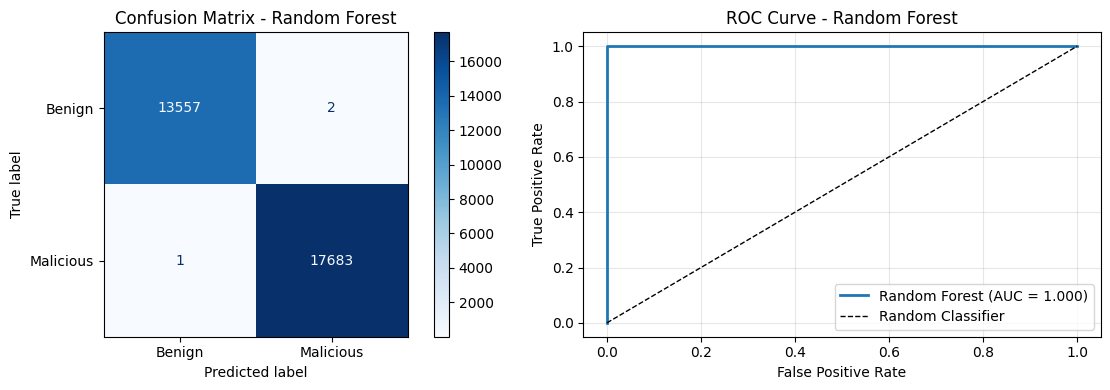


 Results for XGBoost
------------------------------
 Accuracy:  0.9999
 Precision: 0.9999
 Recall:    0.9999
 F1-Score:  0.9999
 ROC-AUC:   1.0000

 Classification Report:
              precision    recall  f1-score   support

      Benign       1.00      1.00      1.00     13559
   Malicious       1.00      1.00      1.00     17684

    accuracy                           1.00     31243
   macro avg       1.00      1.00      1.00     31243
weighted avg       1.00      1.00      1.00     31243



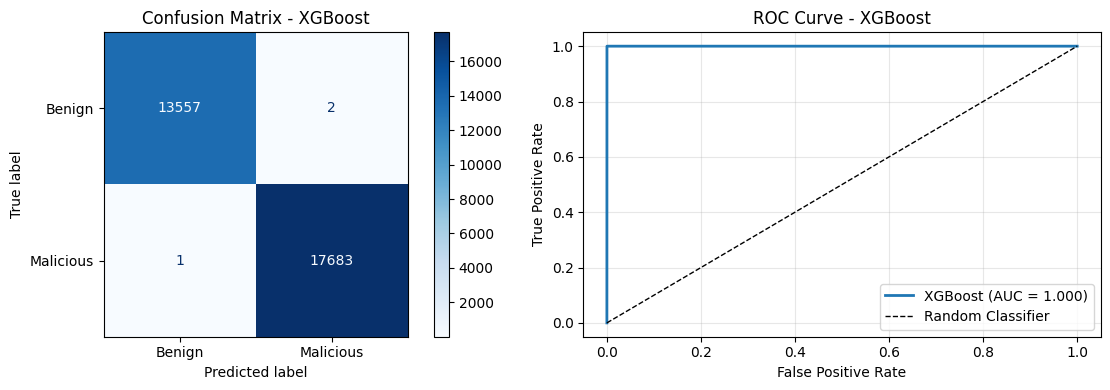

In [33]:
# 6. COMPREHENSIVE MODEL EVALUATION

print("\n" + "="*50)
print("MODEL EVALUATION")
print("="*50)

def evaluate_model(model, model_name, X_test, y_test):
    """A comprehensive function to evaluate and visualize model performance."""
    print(f"\n Results for {model_name}")
    print("-" * 30)
    
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    print(f" Accuracy:  {accuracy:.4f}")
    print(f" Precision: {precision:.4f}")
    print(f" Recall:    {recall:.4f}")
    print(f" F1-Score:  {f1:.4f}")
    print(f" ROC-AUC:   {auc:.4f}")
    
    # Store results
    results[model_name] = {
        'accuracy': accuracy, 'precision': precision,
        'recall': recall, 'f1': f1, 'auc': auc
    }
    
    # Detailed Classification Report
    print("\n Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Benign', 'Malicious']))
    
    # Confusion Matrix Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malicious'])
    disp.plot(cmap='Blues', ax=axes[0])
    axes[0].set_title(f'Confusion Matrix - {model_name}')
    
    # ROC Curve Plot
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    axes[1].plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.3f})', linewidth=2)
    axes[1].plot([0, 1], [0, 1], 'k--', label='Random Classifier', linewidth=1)
    axes[1].set_xlabel('False Positive Rate')
    axes[1].set_ylabel('True Positive Rate')
    axes[1].set_title(f'ROC Curve - {model_name}')
    axes[1].legend(loc='lower right')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return results[model_name]

# Evaluate both models
for name, model in models.items():
    evaluate_model(model, name, X_test_scaled, y_test)


FEATURE IMPORTANCE ANALYSIS
 Top 20 Most Important Features for Detection:
           feature  importance
          FileName    0.234146
DllCharacteristics    0.184119
         DebugSize    0.123933
          DebugRVA    0.094029
    MajorOSVersion    0.093967
MajorLinkerVersion    0.071360
           Machine    0.043395
      ResourceSize    0.041046
SizeOfStackReserve    0.034023
  NumberOfSections    0.024696
 MajorImageVersion    0.018993
            IatVRA    0.016156
         ExportRVA    0.007514
        ExportSize    0.005893
MinorLinkerVersion    0.005785
           md5Hash    0.000790
  BitcoinAddresses    0.000154


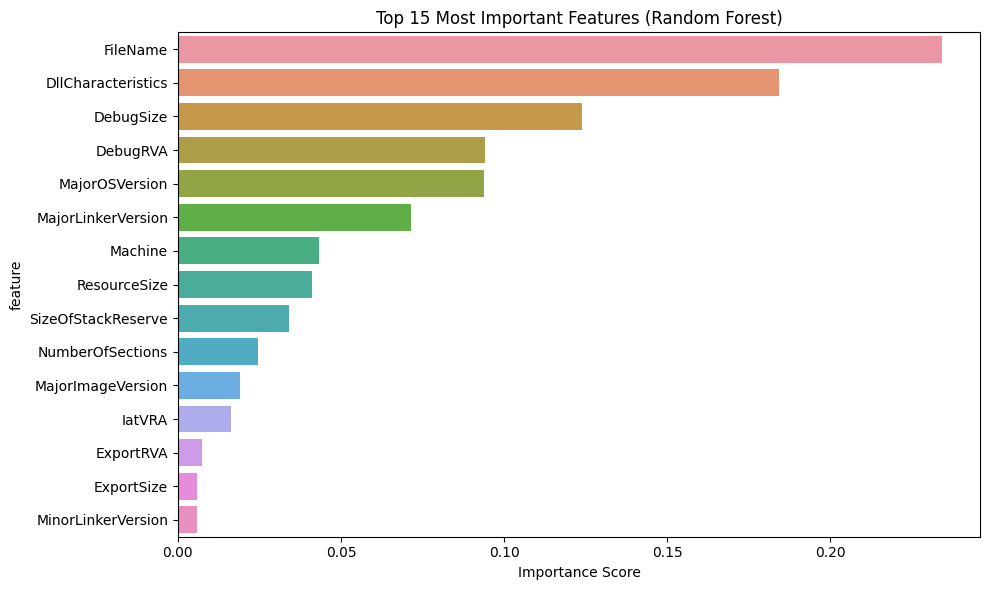

In [34]:
# 7. FEATURE IMPORTANCE ANALYSIS

print("\n" + "="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': feature_cols,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(" Top 20 Most Important Features for Detection:")
print(feature_importance.head(20).to_string(index=False))

# Visualize top features
plt.figure(figsize=(10, 6))
top_n = 15
sns.barplot(x='importance', y='feature', data=feature_importance.head(top_n))
plt.xlabel('Importance Score')
plt.title(f'Top {top_n} Most Important Features (Random Forest)')
plt.tight_layout()
plt.show()

In [35]:
# 8. SAVE MODEL FOR FUTURE USE

print("\n" + "="*50)
print("SAVING ARTIFACTS")
print("="*50)

# Save the best model based on F1-Score 
best_model_name = max(results, key=lambda x: results[x]['f1'])
best_model = models[best_model_name]

joblib.dump(best_model, 'best_ransomware_model2.pkl')
joblib.dump(scaler, 'feature_scaler2.pkl')
joblib.dump(feature_cols, 'feature_columns2.pkl')

print(f" Saved artifacts to disk:")
print(f"   - Best Model ({best_model_name}): 'best_ransomware_model.pkl'")
print(f"   - Feature Scaler: 'feature_scaler.pkl'")
print(f"   - Feature Columns: 'feature_columns.pkl'")
print("\n Model training and evaluation complete!")


SAVING ARTIFACTS
 Saved artifacts to disk:
   - Best Model (Random Forest): 'best_ransomware_model.pkl'
   - Feature Scaler: 'feature_scaler.pkl'
   - Feature Columns: 'feature_columns.pkl'

 Model training and evaluation complete!


In [36]:
import joblib

# Load the old model
model = joblib.load('best_ransomware_model2.pkl')
scaler = joblib.load('feature_scaler2.pkl')
feature_cols = joblib.load('feature_columns2.pkl')

# Saving again with the current (newer) scikit-learn version
joblib.dump(model, 'best_ransomware_model_UPDATED2.pkl')
joblib.dump(scaler, 'feature_scaler_UPDATED2.pkl')
joblib.dump(feature_cols, 'feature_columns_UPDATED2.pkl')

['feature_columns_UPDATED2.pkl']

In [37]:
# ransomware_scanner_final.py
import joblib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def load_model_and_get_features():
    """Load model and dynamically get correct features from training data."""
    # Load model
    model = joblib.load('/kaggle/working/best_ransomware_model.pkl')
    scaler = joblib.load('/kaggle/working/feature_scaler.pkl')
    
    # Get the actual features used during training
    # These are the columns from X_train that your model was trained on
    # Since we didn't save them, we need to reconstruct them
    
    # Based on dataset, the actual features should be:
    actual_features = [
        'Machine', 'DebugSize', 'DebugRVA', 'MajorImageVersion', 
        'MajorOSVersion', 'ExportRVA', 'ExportSize', 'IatVRA', 
        'MajorLinkerVersion', 'MinorLinkerVersion', 'NumberOfSections', 
        'SizeOfStackReserve', 'DllCharacteristics', 'ResourceSize', 
        'BitcoinAddresses'
    ]
    
    # But, the model has 17 features, so missing 2
    # Let's check what other features might be in dataset
    print("  Model expects 17 features but we only have 15 listed")
    print("   Some features might have been created during preprocessing")
    
    # Alternative: Get features from the training data if available
    try:
        # Try to load the original training data features
        feature_columns = joblib.load('/kaggle/working/feature_columns.pkl')
        print(f" Loaded {len(feature_columns)} features from saved file")
        return model, scaler, feature_columns
    except:
        print(" Could not load feature columns file")
        
        # Last resort: Use generic feature names based on model
        n_features = len(model.feature_importances_)
        feature_columns = [f'Feature_{i}' for i in range(n_features)]
        print(f"  Using generic feature names: {n_features} features")
        
        return model, scaler, feature_columns

def create_sample_features(feature_columns):
    """Create sample features based on the actual feature names."""
    print(f"\n Creating sample features for {len(feature_columns)} features")
    
    # Common values for PE file features
    common_values = {
        'Machine': 34404,           # IMAGE_FILE_MACHINE_I386
        'DebugSize': 0,
        'DebugRVA': 0,
        'MajorImageVersion': 0,
        'MajorOSVersion': 6,        # Windows Vista/7/8/10
        'ExportRVA': 0,
        'ExportSize': 0,
        'IatVRA': 4096,
        'MajorLinkerVersion': 11,
        'MinorLinkerVersion': 0,
        'NumberOfSections': 4,
        'SizeOfStackReserve': 1048576,
        'DllCharacteristics': 512,   # IMAGE_DLLCHARACTERISTICS_NX_COMPAT
        'ResourceSize': 0,
        'BitcoinAddresses': 1,
        # Default values for any additional features
        'default': 0
    }
    
    # Create feature dictionary
    sample_features = {}
    for feature in feature_columns:
        if feature in common_values:
            sample_features[feature] = common_values[feature]
        elif 'Feature_' in feature:
            # For generic features, use reasonable defaults
            sample_features[feature] = 0
        else:
            # For any other feature, use default
            sample_features[feature] = common_values['default']
    
    print(f" Created sample with {len(sample_features)} features")
    return sample_features

def main():
    print("="*60)
    print("RANSOMWARE DETECTOR - FINAL PROJECT")
    print("="*60)
    
    # Load model with correct features
    model, scaler, feature_columns = load_model_and_get_features()
    
    print(f"\n Model: {type(model).__name__}")
    print(f" Model expects: {len(feature_columns)} features")
    
    # Create sample features that MATCH the model's expectations
    sample_features = create_sample_features(feature_columns)
    
    # Convert to DataFrame with correct column order
    sample_df = pd.DataFrame([sample_features])[feature_columns]
    
    print(f"\n Sample feature values (first 5):")
    for i, (col, val) in enumerate(zip(feature_columns[:5], sample_df.iloc[0, :5])):
        print(f"   {i+1}. {col}: {val}")
    
    # Scale and predict
    sample_scaled = scaler.transform(sample_df)
    prediction = model.predict(sample_scaled)[0]
    probability = model.predict_proba(sample_scaled)[0]
    
    # Interpret results
    if prediction == 1:
        result = " MALICIOUS (Ransomware Detected!)"
        confidence = probability[1] * 100
    else:
        result = " BENIGN (Safe File)"
        confidence = probability[0] * 100
    
    print(f"\n PREDICTION RESULT:")
    print(f"   {result}")
    print(f"   Confidence: {confidence:.1f}%")
    print(f"   Probabilities: [Benign: {probability[0]:.3f}, Malicious: {probability[1]:.3f}]")
    
    # Feature importance (if available)
    if hasattr(model, 'feature_importances_'):
        print(f"\n TOP 5 FEATURES FOR DETECTION:")
        
        # Create importance DataFrame
        importance_df = pd.DataFrame({
            'Feature': feature_columns,
            'Importance': model.feature_importances_
        }).sort_values('Importance', ascending=False).head(5)
        
        # Print as table
        print(importance_df.to_string(index=False))
        
        # Check for BitcoinAddresses (important for your report)
        if 'BitcoinAddresses' in feature_columns:
            bitcoin_idx = feature_columns.index('BitcoinAddresses')
            bitcoin_imp = model.feature_importances_[bitcoin_idx]
            rank = (model.feature_importances_ > bitcoin_imp).sum() + 1
            print(f"\n BitcoinAddresses is ranked #{rank} in importance")
    
    print("\n" + "="*60)
    print(" DEMO COMPLETE - Ready for Project Presentation!")
    print("="*60)

if __name__ == "__main__":
    main()

RANSOMWARE DETECTOR - FINAL PROJECT
  Model expects 17 features but we only have 15 listed
   Some features might have been created during preprocessing
 Loaded 17 features from saved file

 Model: RandomForestClassifier
 Model expects: 17 features

 Creating sample features for 17 features
 Created sample with 17 features

 Sample feature values (first 5):
   1. FileName: 0
   2. md5Hash: 0
   3. Machine: 34404
   4. DebugSize: 0
   5. DebugRVA: 0

 PREDICTION RESULT:
    BENIGN (Safe File)
   Confidence: 88.5%
   Probabilities: [Benign: 0.885, Malicious: 0.115]

 TOP 5 FEATURES FOR DETECTION:
           Feature  Importance
          FileName    0.234146
DllCharacteristics    0.184119
         DebugSize    0.123933
          DebugRVA    0.094029
    MajorOSVersion    0.093967

 BitcoinAddresses is ranked #17 in importance

 DEMO COMPLETE - Ready for Project Presentation!
